### Random Forest Extension

This notebook extends the Decision Tree model by implementing **Random Forest**, an ensemble learning technique that combines multiple decision trees to improve predictive accuracy and generalization.

- **Reduces overfitting** by averaging predictions across multiple trees.
- **Handles noisy data better** than a single decision tree.
- **More stable predictions** by reducing variance in model outputs.

Steps Covered:
- **Train and evaluate a baseline Random Forest model**.
- **Compare performance** between a single Decision Tree and a Random Forest.
- **Perform hyperparameter tuning** to find the best Random Forest configuration.
- **Analyze feature importance** using:
   - Standard Feature Importance
   - Permutation Feature Importance (PFI)
- **Generate Partial Dependence Plots (PDPs)** to visualize feature effects.
- **Investigate the bias-variance tradeoff** between Decision Tree and Random Forest.
- **Perform Out-of-Bag (OOB) Error Estimation** for unbiased performance evaluation.
- **Visualize individual trees** from the Random Forest.

By the end, we will have a well-optimized **Random Forest model** that improves upon the Decision Tree baseline.


In [1]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier 
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import seaborn as sns
import joblib

In [2]:
# Load training and testing data
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
# Load the final holdout test set
X_final_test = np.load("X_final_test.npy")
y_final_test = np.load("y_final_test.npy")


#### Training a Random Forest (Ensemble of Trees)
A baseline Random Forest model is trained to evaluate its performance compared to a single Decision Tree. This step confirms whether the ensemble method improves generalization.


In [3]:
# Train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
random_forest.fit(X_train, y_train)

print("Random Forest Model Training Complete!")


Random Forest Model Training Complete!


#### Evaluating Random Forest Performance
Training and test accuracy are examined to determine if Random Forest achieves better performance than a single decision tree. An increase in test accuracy without a significant rise in training accuracy indicates effective generalization.

In [4]:
# Compute accuracy
rf_train_accuracy = accuracy_score(y_train, random_forest.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, random_forest.predict(X_test))

# Display results
print(f"Random Forest - Training Accuracy: {rf_train_accuracy:.4f}")
print(f"Random Forest - Test Accuracy: {rf_test_accuracy:.4f}")


Random Forest - Training Accuracy: 0.9992
Random Forest - Test Accuracy: 0.9987


#### Compare Decision Tree vs. Random Forest
A comparison is made to assess whether using multiple trees in Random Forest leads to higher test accuracy compared to a single Decision Tree. A significant improvement would indicate that ensemble averaging is beneficial.

In [5]:
# Load the final decision tree model
final_tree = joblib.load("final_decision_tree.pkl")

# Load precomputed accuracy values if available
try:
    dt_train_accuracy = np.load("final_tree_train_accuracy.npy")
    dt_test_accuracy = np.load("final_tree_test_accuracy.npy")
    print(f"Loaded Decision Tree Accuracy | Train: {dt_train_accuracy:.4f}, Test: {dt_test_accuracy:.4f}")
except FileNotFoundError:
    print("Precomputed accuracy not found, recalculating...")
    dt_train_accuracy = accuracy_score(y_train, final_tree.predict(X_train))
    dt_test_accuracy = accuracy_score(y_test, final_tree.predict(X_test))
    np.save("final_tree_train_accuracy.npy", dt_train_accuracy)
    np.save("final_tree_test_accuracy.npy", dt_test_accuracy)

# Compare Decision Tree vs. Random Forest
comparison_df = pd.DataFrame({
    "Model": ["Decision Tree (Depth=15)", "Random Forest (100 Trees)"],
    "Test Accuracy": [dt_test_accuracy, rf_test_accuracy]
})

# Display results
display(comparison_df)


Loaded Decision Tree Accuracy | Train: 0.9540, Test: 0.9501


,Model,Test Accuracy
0,Decision Tree (Depth=15),0.9500545851528385
1,Random Forest (100 Trees),0.998726


#### Hyperparameter Tuning 
Hyperparameters such as the number of trees, depth, and minimum split criteria are optimized to maximize test accuracy while maintaining efficiency. A structured search ensures that the best-performing model configuration is identified.

In [6]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [10, 15, 20, None],  # Tree depth
    "min_samples_split": [2, 5, 10],  # Minimum samples to split
    "min_samples_leaf": [1, 2, 5]  # Minimum samples per leaf
}

# Perform Grid Search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_rf_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print("Best Parameters for Random Forest:", best_rf_params)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [7]:
# Train the best Random Forest Model
best_rf_model.fit(X_train, y_train)

# Compute Accuracy on Train, Test, and Final Holdout Set
rf_train_acc = accuracy_score(y_train, best_rf_model.predict(X_train))
rf_test_acc = accuracy_score(y_test, best_rf_model.predict(X_test))
rf_final_test_acc = accuracy_score(y_final_test, best_rf_model.predict(X_final_test))

# Display Performance
print(f"Best Random Forest Model Performance:")
print(f"Training Accuracy: {rf_train_acc:.4f}")
print(f"Test Accuracy: {rf_test_acc:.4f}")
print(f"Final Holdout Accuracy: {rf_final_test_acc:.4f}")


Best Random Forest Model Performance:
Training Accuracy: 1.0000
Test Accuracy: 0.9995
Final Holdout Accuracy: 1.0000


#### Feature Importance Analysis
Feature importance is analyzed to determine which attributes contribute most to classification decisions. If a feature is consistently ranked highly across different methods (standard importance and permutation importance), it plays a significant role in prediction.

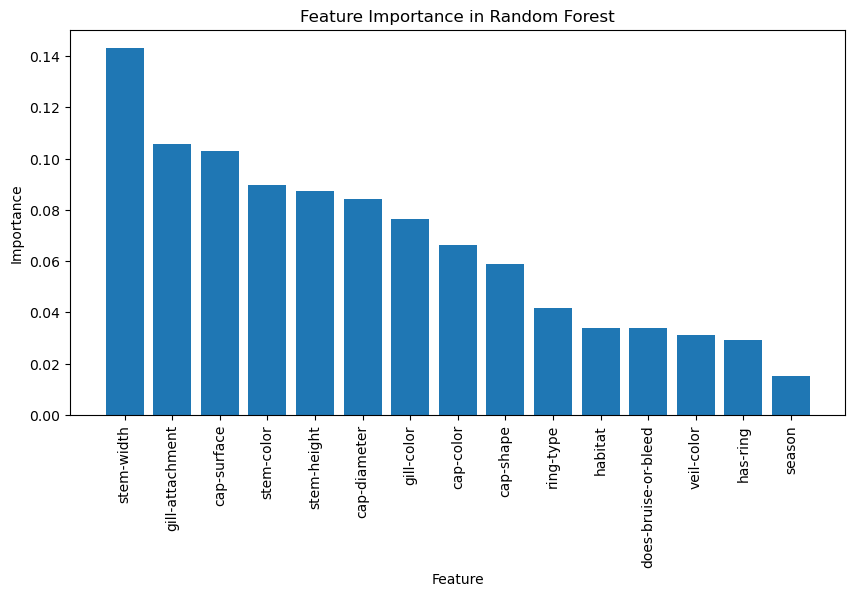

In [8]:
# Load feature names from saved file
feature_names = np.load("feature_names.npy", allow_pickle=True)

# Ensure the number of features match the trained model
if len(feature_names) != len(best_rf_model.feature_importances_):
    raise ValueError(
        f"Feature mismatch: {len(feature_names)} in file vs. {len(best_rf_model.feature_importances_)} in model"
    )

# Extract feature importance
rf_feature_importance = best_rf_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(rf_feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 5))

plt.bar(range(len(feature_names)), rf_feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_idx], rotation=90)

# Add labels and title
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")

# Display the plot
plt.show()


In [9]:
best_rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Save the trained random forest model
joblib.dump(best_rf_model, "best_random_forest.pkl")
print("Best Random Forest Model Saved!")


Best Random Forest Model Saved!


In [10]:
# Load Decision Tree Model
if 'final_tree' not in globals():
    final_tree = joblib.load("final_decision_tree.pkl")
    print("final_tree loaded successfully!")

# Load Random Forest Model
if 'best_rf_model' not in globals():
    best_rf_model = joblib.load("best_random_forest.pkl")
    print("best_rf_model loaded successfully!")


#### Permutation Feature Importance
Permutation Feature Importance is computed for both Decision Tree and Random Forest to assess the impact of each feature on model predictions. A feature is considered important if shuffling its values significantly reduces accuracy.

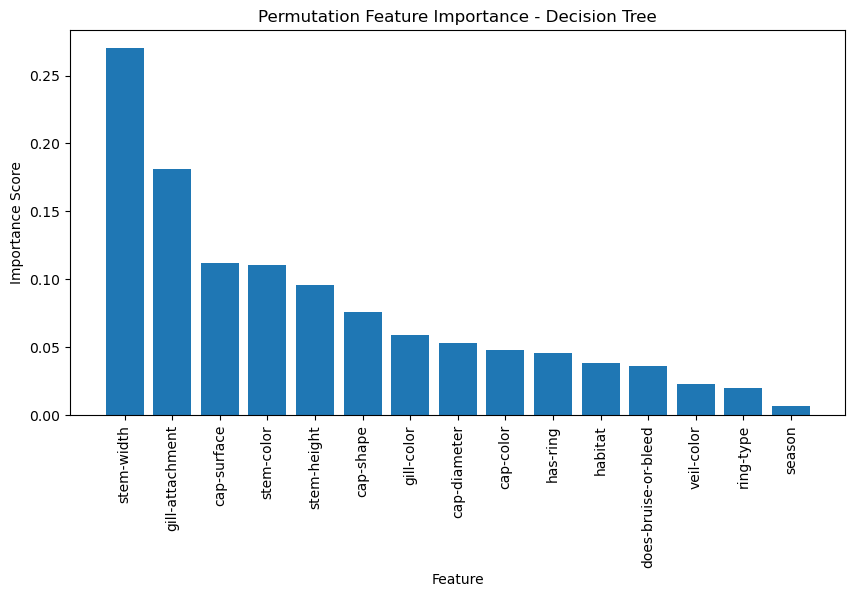

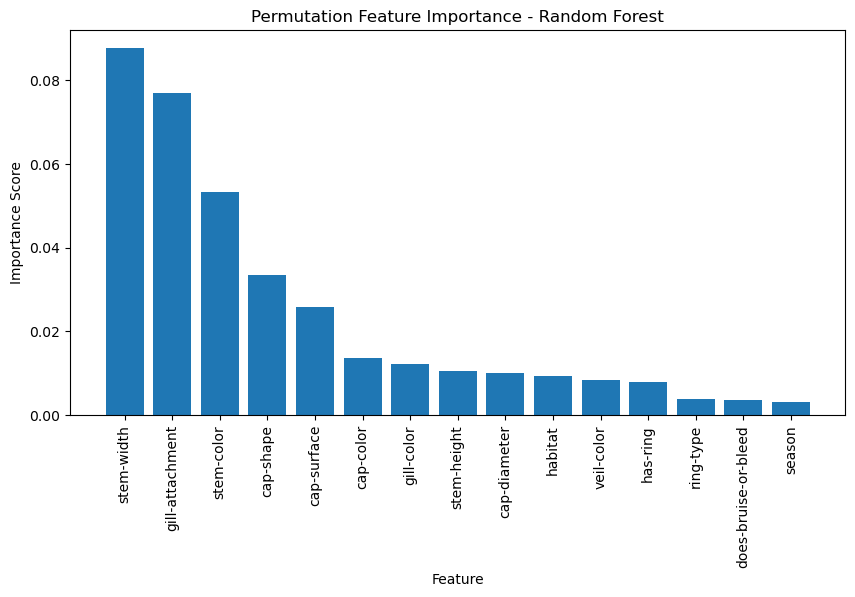

In [11]:
# Ensure test set and model are loaded
if 'best_rf_model' in globals() and 'final_tree' in globals():
    
    # Compute Permutation Feature Importance for Decision Tree
    dt_perm_importance = permutation_importance(final_tree, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42)
    
    # Compute Permutation Feature Importance for Random Forest
    rf_perm_importance = permutation_importance(best_rf_model, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42)
    
    # Extract importance values
    dt_importance_vals = dt_perm_importance.importances_mean
    rf_importance_vals = rf_perm_importance.importances_mean
    
    # Sort feature indices based on importance
    sorted_dt_idx = np.argsort(dt_importance_vals)[::-1]
    sorted_rf_idx = np.argsort(rf_importance_vals)[::-1]
    
    # Plot Decision Tree Permutation Importance
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_names)), dt_importance_vals[sorted_dt_idx], align="center")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_dt_idx], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance Score")
    plt.title("Permutation Feature Importance - Decision Tree")
    plt.show()
    
    # Plot Random Forest Permutation Importance
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_names)), rf_importance_vals[sorted_rf_idx], align="center")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_rf_idx], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance Score")
    plt.title("Permutation Feature Importance - Random Forest")
    plt.show()
    
else:
    print("Ensure final_tree and best_rf_model are properly defined before running this cell.")


In [12]:
# Load feature names from saved file
feature_names = np.load("feature_names.npy", allow_pickle=True)
print("Loaded Feature Names:", feature_names)



Loaded Feature Names: ['cap-diameter' 'cap-shape' 'cap-surface' 'cap-color'
 'does-bruise-or-bleed' 'gill-attachment' 'gill-color' 'stem-height'
 'stem-width' 'stem-color' 'veil-color' 'has-ring' 'ring-type' 'habitat'
 'season']


#### Partial Dependence Plots
The relationship between selected features and model predictions is visualized using PDPs. A strong and clear pattern in the plots suggests a significant influence of that feature on classification outcomes.


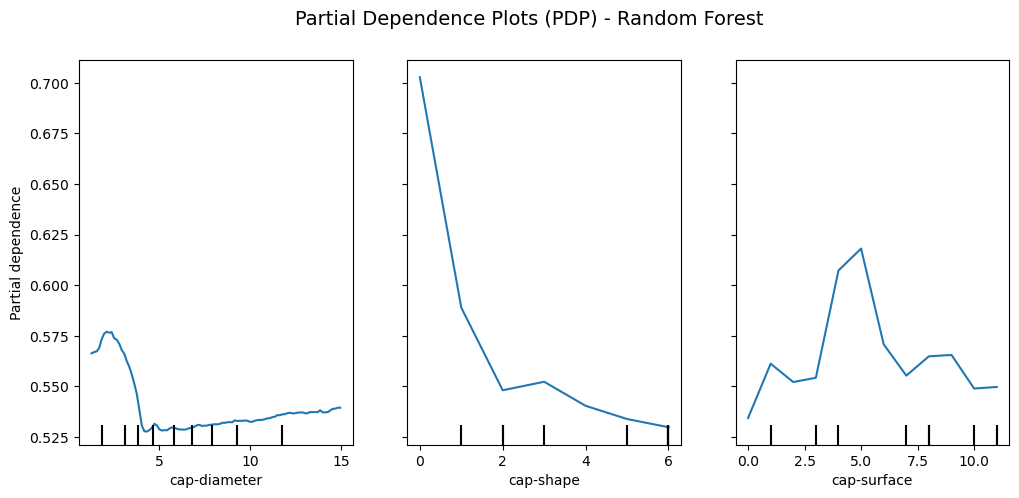

In [13]:
# Load the correct feature names
feature_names = np.load("feature_names.npy", allow_pickle=True)

# Select three valid features for PDP
selected_features = [0, 1, 2]  # Indices of features in X_test

# Ensure Random Forest Model is Loaded
if 'best_rf_model' in globals():
    # Generate PDP for selected features
    fig, ax = plt.subplots(figsize=(12, 5))
    pdp_display = PartialDependenceDisplay.from_estimator(
        best_rf_model, X_test, features=selected_features, feature_names=feature_names, ax=ax
    )
    plt.suptitle("Partial Dependence Plots (PDP) - Random Forest", fontsize=14)
    plt.show()
else:
    print("Ensure `best_rf_model` is properly loaded before running this cell.")


#### Effect of Increasing Trees (Learning Curve)
The impact of increasing the number of trees on model accuracy is examined. If accuracy continues to improve, adding more trees enhances performance. If accuracy plateaus, additional trees no longer provide benefits.

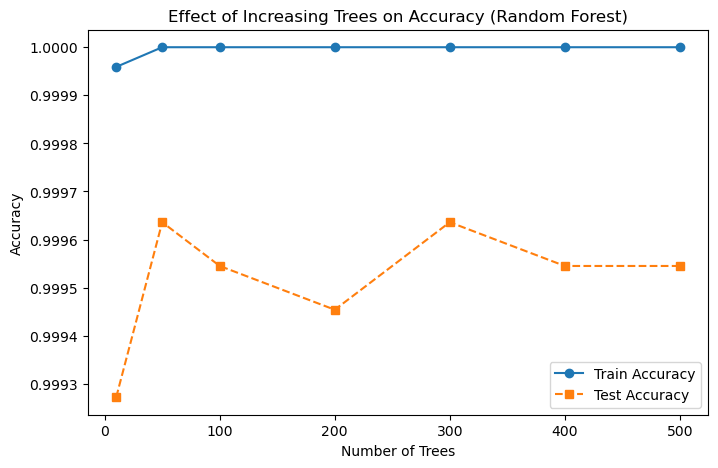

In [14]:
# Define range of trees
n_trees = [10, 50, 100, 200, 300, 400, 500]
train_accuracies = []
test_accuracies = []

# Train models with different numbers of trees
for n in n_trees:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Compute accuracies
    train_acc = accuracy_score(y_train, rf_model.predict(X_train))
    test_acc = accuracy_score(y_test, rf_model.predict(X_test))

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(n_trees, train_accuracies, marker='o', label="Train Accuracy")
plt.plot(n_trees, test_accuracies, marker='s', label="Test Accuracy", linestyle="dashed")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Effect of Increasing Trees on Accuracy (Random Forest)")
plt.legend()
plt.show()


#### Class Probability Distribution (Confidence Analysis)
The distribution of predicted class probabilities is examined to assess model confidence. A high concentration of probabilities near 0 or 1 suggests high confidence, while many predictions near 0.5 indicate uncertainty in classification.

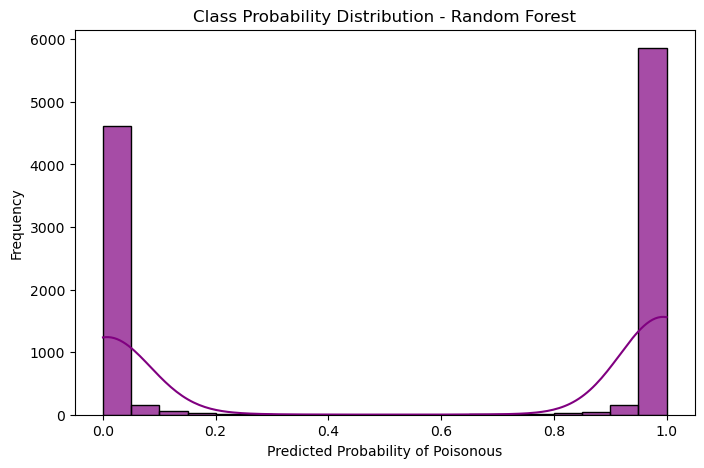

In [15]:
# Get class probabilities from Random Forest model
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]  # Probability of being poisonous

# Plot probability distribution
plt.figure(figsize=(8, 5))
sns.histplot(rf_probs, bins=20, kde=True, color="purple", alpha=0.7)
plt.xlabel("Predicted Probability of Poisonous")
plt.ylabel("Frequency")
plt.title("Class Probability Distribution - Random Forest")
plt.show()


#### Out-of-Bag (OOB) Error Estimation
OOB error provides an unbiased estimate of test accuracy using bootstrap sampling. If the OOB score closely matches test accuracy, the model generalizes well without requiring additional validation data.

In [16]:
# Train Random Forest with OOB
oob_rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
oob_rf.fit(X_train, y_train)

# OOB Score
print("Out-of-Bag Score (Random Forest):", oob_rf.oob_score_)


Out-of-Bag Score (Random Forest): 0.9996110940538327


#### Bias-Variance Tradeoff: Decision Tree vs. Random Forest
The tradeoff between bias and variance is analyzed by training models on different dataset sizes. If Random Forest consistently maintains better test accuracy, it indicates that variance is reduced while preserving predictive power.

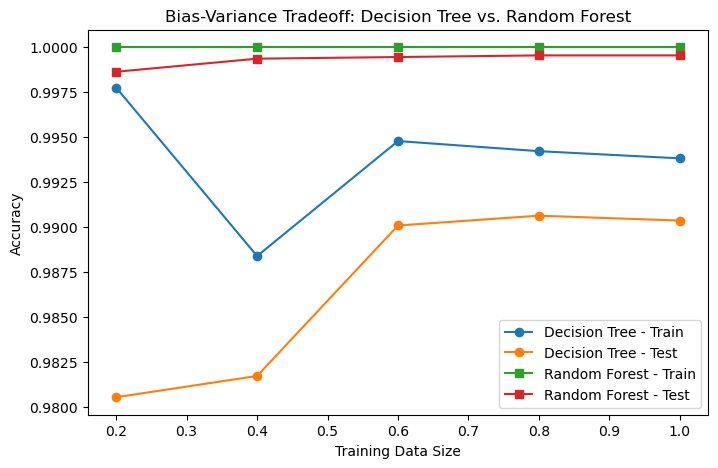

In [17]:
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
dt_train_acc = []
dt_test_acc = []
rf_train_acc = []
rf_test_acc = []

for size in train_sizes:
    # Subset data
    X_train_sub = X_train[:int(size * len(X_train))]
    y_train_sub = y_train[:int(size * len(y_train))]

    # Train Decision Tree
    dt_model = DecisionTreeClassifier(max_depth=15, random_state=42)
    dt_model.fit(X_train_sub, y_train_sub)
    dt_train_acc.append(accuracy_score(y_train_sub, dt_model.predict(X_train_sub)))
    dt_test_acc.append(accuracy_score(y_test, dt_model.predict(X_test)))

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_sub, y_train_sub)
    rf_train_acc.append(accuracy_score(y_train_sub, rf_model.predict(X_train_sub)))
    rf_test_acc.append(accuracy_score(y_test, rf_model.predict(X_test)))

# Plot bias-variance tradeoff
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, dt_train_acc, "o-", label="Decision Tree - Train")
plt.plot(train_sizes, dt_test_acc, "o-", label="Decision Tree - Test")
plt.plot(train_sizes, rf_train_acc, "s-", label="Random Forest - Train")
plt.plot(train_sizes, rf_test_acc, "s-", label="Random Forest - Test")
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.title("Bias-Variance Tradeoff: Decision Tree vs. Random Forest")
plt.legend()
plt.show()


#### Visualizing One Tree from the Random Forest
A single tree from the Random Forest is visualized to understand its individual decision-making process. This helps in interpreting the structure of the ensemble model and examining how decisions are made within a single component tree.

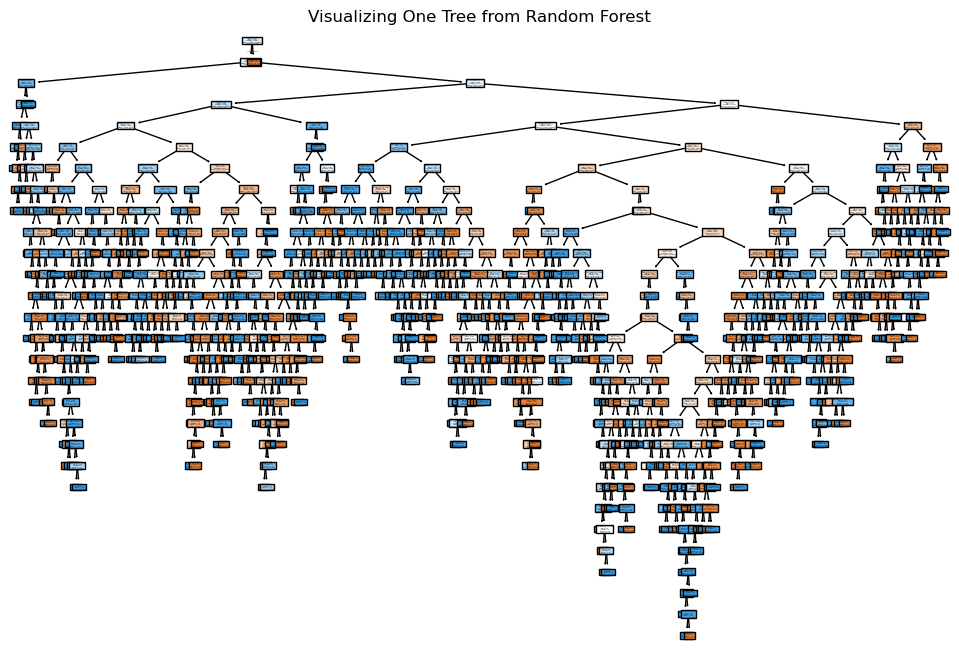

In [18]:
# Select the first tree from Random Forest
first_tree = best_rf_model.estimators_[0]

# Plot the tree structure
plt.figure(figsize=(12, 8))
plot_tree(first_tree, feature_names=feature_names, class_names=["Edible", "Poisonous"], filled=True)
plt.title("Visualizing One Tree from Random Forest")
plt.show()
